# 独自データの分類
# モデルの性能比較


In [4]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples
import inspect
from jupyterthemes import jtplot
jtplot.style()
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)



## データ用意

In [5]:
file = open("thick.txt", mode='r')
lines = file.readlines()
file.close()

arr_whole_data = [];
arr_whole_target = [];
for line in lines:
    arr = line.strip().split(",")
    arr_whole_data.append([int(arr[0]), int(arr[1])])
    arr_whole_target.append(int(arr[2]))

arr_whole_data[0:5]
arr_whole_target[0:5]

whole_data = np.array(arr_whole_data, np.float32)/np.array([640,480], np.float32)
whole_target = np.array(arr_whole_target, np.int32)

whole_data[0:5]
whole_target[0:5]

test_len = int(len(whole_data)/4)

#データセットを作る
dataset = datasets.TupleDataset(whole_data, whole_target)

#split_dataset_randomで、ランダムにデータセットを分けられる　学習データとテストデータに分ける
test, train = datasets.split_dataset_random(dataset, test_len, 1234)

#学習データ数
len(train)

#イテレータの作成
batch_size = 10
train_iter = iterators.SerialIterator(train, batch_size=batch_size)
test_iter = iterators.SerialIterator(test, batch_size=batch_size, repeat=False, shuffle=False)

[[618, 114], [596, 108], [483, 109], [431, 111], [406, 118]]

[0, 0, 0, 0, 0]

array([[ 0.96562499,  0.2375    ],
       [ 0.93124998,  0.22499999],
       [ 0.75468749,  0.22708334],
       [ 0.67343748,  0.23125   ],
       [ 0.63437498,  0.24583334]], dtype=float32)

array([0, 0, 0, 0, 0])

429

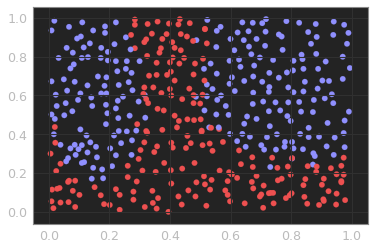

In [6]:
#学習用データの表示
#Tupleデータセットを可視化する…データセットから数値を抜き出してnp.arrayにもう一度戻す
def plotWholeData():
    X = np.array([[dt[0][0] for dt in train],[dt[0][1] for dt in train]], np.float32).T
    y = np.array([dt[1] for dt in train], np.int32)
    cm = generate_cmap(['#EE5050', '#9090FF'])
    plt.scatter(X[:,0], X[:,1], c=y, cmap = cm)

plotWholeData()

## モデルの用意・学習

今回はモデルを2つ（SimpleModel, Model2）を用意して性能を比較する

In [7]:
#モデルを用意
class SimpleModel(Chain):
    def __init__(self, n_out):
        super(SimpleModel, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 100)
            self.l2 = L.Linear(None, 100)
            self.l3 = L.Linear(None, n_out)
    
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

class Model2(Chain):
    def __init__(self, n_out):
        super(Model2, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 100)
            self.l2 = L.Linear(None, 80)
            self.l3 = L.Linear(None, 80)
            self.l4 = L.Linear(None, 50)
            self.l5 = L.Linear(None, n_out)
    
    def __call__(self, x):
        h1 = F.tanh(self.l1(x))
        h2 = F.tanh(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        h4 = F.relu(self.l4(h3))
        y = self.l5(h4)
        return y

## Trainerを取得するメソッド作成

思い通りのExtensionを持ったTrainerを作るまでに手間が掛かるので

メソッド化


In [8]:
def GetTrainerForModel(model, train_iter, test_iter, stop_epoch, log_name):
        optimizer = optimizers.Adam()
        classifier = L.Classifier(model)
        optimizer.setup(classifier)
        updater = training.StandardUpdater(train_iter, optimizer)
        trainer = training.Trainer(updater, (stop_epoch, 'epoch'))
        
        trainer.extend(extensions.Evaluator(test_iter, classifier))
        trainer.extend(extensions.LogReport(log_name=log_name))
        trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss', 'elapsed_time']))
        return trainer

In [9]:
#GetTrainerForModelメソッドでそれぞれのモデルについてtrainerを得る

epoch = 200

model1 = SimpleModel(2)
trainer1 = GetTrainerForModel(model1, train_iter, test_iter, epoch, 'trainLog1')

model2 = Model2(2)
trainer2 = GetTrainerForModel(model2, train_iter, test_iter, epoch, 'trainLog2')

In [10]:
train_iter.reset()
test_iter.reset()
trainer1.run()

epoch       main/accuracy  main/loss   elapsed_time
1           0.702326       0.624595    0.0890746     
2           0.702326       0.58828     0.217151      
3           0.72093        0.558592    0.34124       
4           0.739535       0.531198    0.444312      
5           0.755814       0.490713    0.545385      
6           0.734884       0.476141    0.640451      
7           0.753488       0.436137    0.734518      
8           0.786047       0.419242    0.851602      
9           0.809302       0.384462    1.03873       
10          0.819048       0.37669     1.15982       
11          0.832558       0.36918     1.28191       
12          0.848837       0.345303    1.39398       
13          0.860465       0.334314    1.51307       
14          0.851163       0.319799    1.61916       
15          0.862791       0.30673     1.76025       
16          0.87907        0.299282    1.87433       
17          0.893023       0.283651    1.98941       
18          0.893023       0.2

In [11]:
train_iter.reset()
test_iter.reset()
trainer2.run()

epoch       main/accuracy  main/loss   elapsed_time
1           0.648837       0.624194    0.131093      
2           0.704651       0.590909    0.290205      
3           0.716279       0.534675    0.426301      
4           0.732558       0.466528    0.558395      
5           0.767442       0.407586    0.685484      
6           0.830233       0.354745    0.8496        
7           0.867442       0.305479    1.01372       
8           0.888372       0.263569    1.17783       
9           0.890698       0.249556    1.32494       
10          0.895238       0.249714    1.48705       
11          0.911628       0.212786    1.64016       
12          0.911628       0.212018    1.77526       
13          0.927907       0.184943    1.91235       
14          0.906977       0.225275    2.05646       
15          0.87907        0.252695    2.20956       
16          0.925581       0.191068    2.35367       
17          0.911628       0.20865     2.49777       
18          0.923256       0.1

## 性能比較

result/trainLog1
2017-10-29 14:01:41


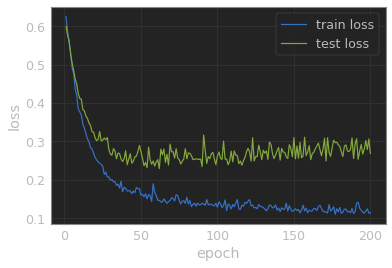

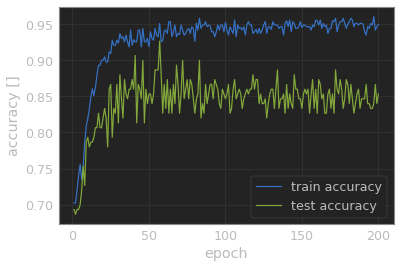

result/trainLog2
2017-10-29 14:02:14


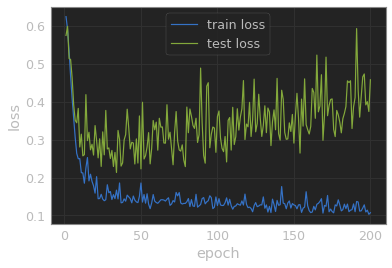

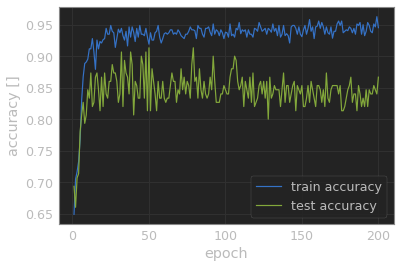

In [12]:
from mylib.PlotUtil import PlotLossAndAccuracy

PlotLossAndAccuracy('result', 'trainLog1')
plt.show()
PlotLossAndAccuracy('result', 'trainLog2')
plt.show()

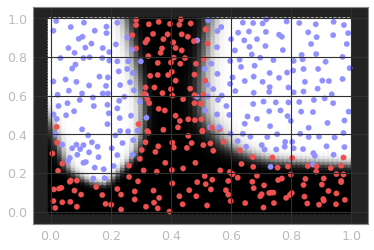

In [13]:
#格子点サンプルの用意と判別結果の取得
xx, yy = np.meshgrid(np.arange(0,1.0,0.015), np.arange(0,1.0,0.015))
mesh = np.array(np.c_[xx.ravel(), yy.ravel()], np.float32)

#学習済みのモデルの出力をsoftmaxで確率とし、クラス1の確率をとってくる
y_mesh = F.softmax(model1(mesh)).data[:,1]

#境界を表示
cm = generate_cmap(["#000000", "#FFFFFF"])
plt.scatter(mesh[:,0], mesh[:,1], c=y_mesh, cmap=cm)

#学習データを表示
plotWholeData()

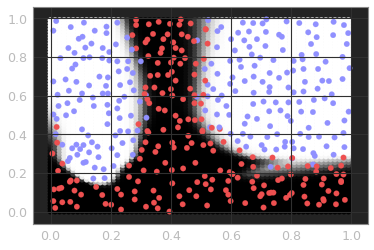

In [14]:
#格子点サンプルの用意と判別結果の取得
xx, yy = np.meshgrid(np.arange(0,1.0,0.015), np.arange(0,1.0,0.015))
mesh = np.array(np.c_[xx.ravel(), yy.ravel()], np.float32)

#学習済みのモデルの出力をsoftmaxで確率とし、クラス1の確率をとってくる
y_mesh = F.softmax(model2(mesh)).data[:,1]

#境界を表示
cm = generate_cmap(["#000000", "#FFFFFF"])
plt.scatter(mesh[:,0], mesh[:,1], c=y_mesh, cmap=cm)

#学習データを表示
plotWholeData()